In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("df_model_ready_train.csv")

Saving df_model_ready_train.csv to df_model_ready_train.csv


In [4]:
# === Anzahl der tatsächlichen Trainingsbeispiele nach Fraud-Filter ===
if "label_fraud_bin" in df.columns:
    fraud_count = (df["label_fraud_bin"] == 1).sum()
    normal_count = (df["label_fraud_bin"] == 0).sum()
    total_count = len(df)

    print(f"🧾 Gesamt: {total_count} Transaktionen")
    print(f"✅ NORMAL (0): {normal_count}")
    print(f"🚨 FRAUD (1): {fraud_count}")
else:
    print("⚠️ 'label_fraud_bin' nicht gefunden – keine Fraud-Statistik möglich.")


🧾 Gesamt: 151565 Transaktionen
✅ NORMAL (0): 148318
🚨 FRAUD (1): 3247


In [5]:
# === 2a. Falls "damage"-Spalte vorhanden ist, entfernen ===
if "damage" in df.columns:
    df = df.drop(columns=["damage"])

In [6]:
# === 2. Zielvariable trennen ===
# Ensure the target variable is not included in the features X
if "label_fraud_bin" in df.columns:
    y = df["label_fraud_bin"]
    X = df.drop(columns=["label_fraud_bin"])
else:
    # Handle cases where the target column might be missing after some operations
    y = None # Or assign a default/error state
    X = df.copy() # Work with the full dataframe if no target is specified

In [7]:
# === 3. Nicht-numerische Spalten identifizieren und entfernen ===
# Select only numeric columns for the autoencoder
X_numeric = X.select_dtypes(include=['number'])

In [8]:
# === 4. Fehlende Werte behandeln (nur für numerische Spalten) ===
# Calculate the mean only for the numeric columns and fill NaNs
X_numeric.fillna(X_numeric.mean(), inplace=True)

In [9]:
# === 5. Feature-Skalierung (nur für numerische Spalten) ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric) # Use X_numeric here

In [10]:
# === 1. Architektur definieren ===
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
bottleneck = Dense(32, activation='relu')(encoded)  # <–– 32 Neuronen
decoded = Dense(32, activation='relu')(bottleneck)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=bottleneck)

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [11]:
# === 2. Trainings-/Validierungsdaten splitten ===
X_train, X_val = train_test_split(X_scaled, test_size=0.1, random_state=42)

In [12]:
# === 3. EarlyStopping definieren ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [13]:
# === 4. Training mit EarlyStopping ===
autoencoder.fit(
    X_train, X_train,
    epochs=60,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/60
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1588 - val_loss: 0.0071
Epoch 2/60
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0342 - val_loss: 0.0034
Epoch 3/60
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0191 - val_loss: 0.0014
Epoch 4/60
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0114 - val_loss: 0.0017
Epoch 5/60
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0148 - val_loss: 0.0015
Epoch 6/60
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0068 - val_loss: 9.4441e-04
Epoch 7/60
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0073 - val_loss: 0.0012
Epoch 8/60
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0090 - val_loss: 0.0014
Epoch 9/60
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0077 - val_loss: 0.0044
Epoch 10/60
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0066 - val_loss: 8.0465e-04
Epoch 11/60
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0091 - val_loss: 0.0012
Epoch 12/60
42

In [14]:
# === Autoencoder und Scaler speichern ===
autoencoder.save("autoencoder_model.h5")
print("✅ Modell gespeichert: autoencoder_model.h5")

import joblib
joblib.dump(scaler, "scaler.pkl")
print("✅ Scaler gespeichert: scaler.pkl")

from google.colab import files
files.download("autoencoder_model.h5")
files.download("scaler.pkl")

✅ Modell gespeichert: autoencoder_model.h5
✅ Scaler gespeichert: scaler.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# === 7. Extraktion der neuen Features ===
X_bottleneck = encoder.predict(X_scaled)
bottleneck_df = pd.DataFrame(X_bottleneck, columns=[f'ae_feat_{i}' for i in range(X_bottleneck.shape[1])])

4737/4737 ━━━━━━━━━━━━━━━━━━━━ 3s 712us/step


In [16]:
# === 8. Zusammenfügen ===
X_enhanced = pd.concat([df.reset_index(drop=True), bottleneck_df], axis=1)

In [17]:
# === 9. Speichern oder weiterverarbeiten ===
X_enhanced.to_csv("df_mit_autoencoder_features_bottleneck_32.csv", index=False)
print("Neue Features wurden erfolgreich hinzugefügt und gespeichert.")

Neue Features wurden erfolgreich hinzugefügt und gespeichert.


In [18]:
# Anzahl der ursprünglichen Features
print("Originale Features:", df.shape[1])

Originale Features: 42


In [19]:
# Anzahl nach Erweiterung
print("Mit Autoencoder-Features:", X_enhanced.shape[1])

Mit Autoencoder-Features: 74


In [20]:
#from google.colab import files
#files.download("df_mit_autoencoder_features_bottleneck_32.csv")

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


In [22]:
df = X_enhanced

In [23]:
# === 2. Ziel und Features trennen ===
y = df["label_fraud_bin"]
X = df.drop(columns=["label_fraud_bin"])

In [24]:
print("Training auf diesen Features:")
print(X.columns.tolist())


Training auf diesen Features:
['id', 'store_id', 'cash_desk', 'transaction_start', 'transaction_end', 'total_amount', 'n_lines', 'payment_medium', 'label', 'sales_price_sum_x', 'sales_price_mean_x', 'sales_price_max_x', 'camera_certainty_mean_x', 'camera_certainty_min_x', 'was_voided_sum_x', 'category_nunique_x', 'sold_by_weight_sum_x', 'age_restricted_sum_x', 'opening_date', 'location', 'state', 'urbanization', 'sco_introduction', 'has_cash_payment', 'average_price_per_article', 'transaction_duration_seconds', 'articles_per_minute', 'voided_articles_ratio', 'hour', 'weekday', 'snack_count', 'snack_share', 'sales_price_sum_y', 'sales_price_mean_y', 'sales_price_max_y', 'camera_certainty_mean_y', 'camera_certainty_min_y', 'was_voided_sum_y', 'category_nunique_y', 'sold_by_weight_sum_y', 'age_restricted_sum_y', 'ae_feat_0', 'ae_feat_1', 'ae_feat_2', 'ae_feat_3', 'ae_feat_4', 'ae_feat_5', 'ae_feat_6', 'ae_feat_7', 'ae_feat_8', 'ae_feat_9', 'ae_feat_10', 'ae_feat_11', 'ae_feat_12', 'ae_fea

In [25]:
# This effectively drops the original 'object' type columns again
X = X.select_dtypes(include=['number'])

In [26]:
# === 3. Modell trainieren ===
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X, y)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [27]:
import joblib

# Modell speichern
joblib.dump(model, "xgboost_model.pkl")
print("✅ Modell gespeichert: xgboost_model.pkl")


✅ Modell gespeichert: xgboost_model.pkl


In [28]:
# Feature-Namen sichern (für spätere Nutzung beim Input-Alignment)
joblib.dump(model.feature_names_in_, "feature_names.pkl")
print("✅ Feature-Namen gespeichert: feature_names.pkl")


✅ Feature-Namen gespeichert: feature_names.pkl


In [65]:
import shap
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

100%|===================| 151322/151565 [06:18<00:00]       

In [30]:
import numpy as np


In [66]:
top_ae_feats = [col for col in X.columns if col.startswith("ae_feat_")]
shap_means = np.abs(shap_values.values).mean(axis=0)
top_ae_feats_sorted = pd.Series(shap_means, index=X.columns).loc[top_ae_feats].sort_values(ascending=False)

top_3_auto = top_ae_feats_sorted.head(3).index.tolist()
manuelle_feats = ["ae_feat_1", "ae_feat_2", "ae_feat_3", "ae_feat_4", "ae_feat_5",
    "ae_feat_6", "ae_feat_7", "ae_feat_8", "ae_feat_9", "ae_feat_10",
    "ae_feat_11", "ae_feat_12", "ae_feat_13", "ae_feat_14", "ae_feat_15",
    "ae_feat_16", "ae_feat_17", "ae_feat_18", "ae_feat_19", "ae_feat_20",
    "ae_feat_21", "ae_feat_22", "ae_feat_23", "ae_feat_24", "ae_feat_25",
    "ae_feat_26", "ae_feat_27", "ae_feat_28", "ae_feat_29", "ae_feat_30",
    "ae_feat_31"]
top_ae_combined = list(dict.fromkeys(top_3_auto + manuelle_feats))
top_3_ae_feats = top_3_auto


In [67]:
# Alle originalen numerischen Features (ohne ae_feat_* und ohne Target)
original_feats = [col for col in df.select_dtypes(include='number').columns
                  if not col.startswith("ae_feat") and col != "label_fraud_bin"]

# Korrelationen für Top ae_feat_* berechnen
for ae_feat in top_3_ae_feats:
    print(f"\n🔎 Korrelationen von {ae_feat}:")
    correlations = df[original_feats + [ae_feat]].corr()[ae_feat].drop(ae_feat).sort_values(key=abs, ascending=False)
    print(correlations.head(10))




🔎 Korrelationen von ae_feat_15:
age_restricted_sum_x       0.754096
age_restricted_sum_y       0.754096
camera_certainty_mean_y   -0.499302
camera_certainty_mean_x   -0.499302
camera_certainty_min_x    -0.332493
camera_certainty_min_y    -0.332493
sales_price_max_y         -0.212127
sales_price_max_x         -0.212127
has_cash_payment           0.205581
n_lines                   -0.165670
Name: ae_feat_15, dtype: float64

🔎 Korrelationen von ae_feat_6:
sales_price_sum_x               0.708933
sales_price_sum_y               0.708933
total_amount                    0.699150
sales_price_max_x               0.653151
sales_price_max_y               0.653151
n_lines                         0.595639
transaction_duration_seconds    0.591576
was_voided_sum_y                0.545292
was_voided_sum_x                0.545292
average_price_per_article       0.520909
Name: ae_feat_6, dtype: float64

🔎 Korrelationen von ae_feat_14:
was_voided_sum_x          0.756981
was_voided_sum_y          0.7569

In [33]:
X_original = df[original_feats]

In [34]:
X_original = df[original_feats].fillna(df[original_feats].mean())



📊 Prozentuale Zusammensetzung von ae_feat_15 (Ridge Regression):
snack_share                19.166323
age_restricted_sum_x       15.681789
age_restricted_sum_y       15.681789
camera_certainty_mean_y    12.738579
camera_certainty_mean_x    12.738579
snack_count                 7.283046
has_cash_payment            5.598039
was_voided_sum_x            2.030878
was_voided_sum_y            2.030878
sold_by_weight_sum_x        1.116045
dtype: float64


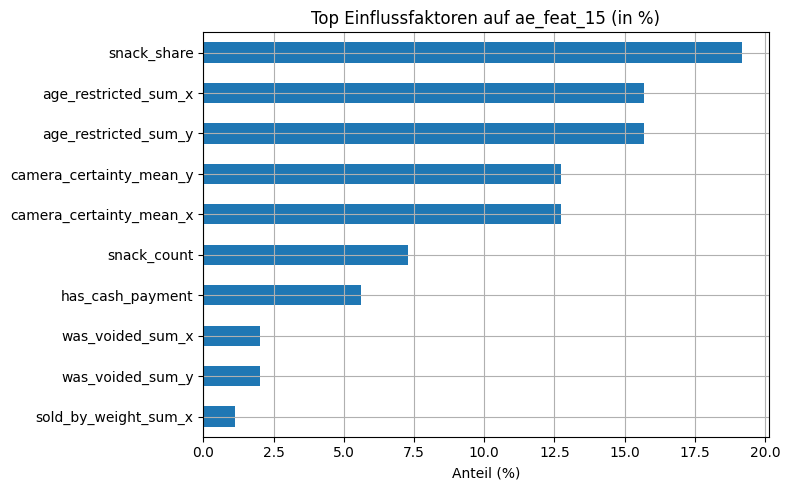


📊 Prozentuale Zusammensetzung von ae_feat_6 (Ridge Regression):
snack_share                32.251405
snack_count                24.285178
was_voided_sum_x            6.669153
was_voided_sum_y            6.669153
camera_certainty_mean_y     6.496348
camera_certainty_mean_x     6.496348
camera_certainty_min_x      3.634384
camera_certainty_min_y      3.634384
has_cash_payment            1.858146
sold_by_weight_sum_x        1.316157
dtype: float64


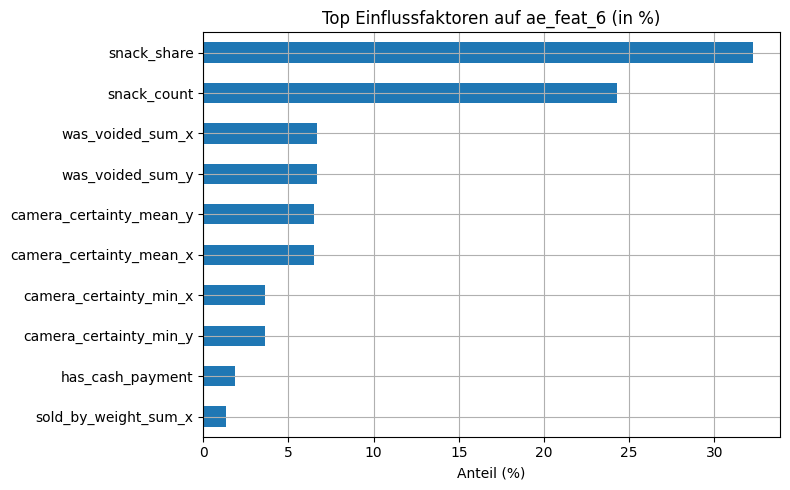


📊 Prozentuale Zusammensetzung von ae_feat_14 (Ridge Regression):
was_voided_sum_x           14.941586
was_voided_sum_y           14.941586
camera_certainty_min_x     13.688696
camera_certainty_min_y     13.688696
snack_share                 7.977251
camera_certainty_mean_x     5.181083
camera_certainty_mean_y     5.181083
snack_count                 3.744129
sold_by_weight_sum_y        3.496940
sold_by_weight_sum_x        3.496940
dtype: float64


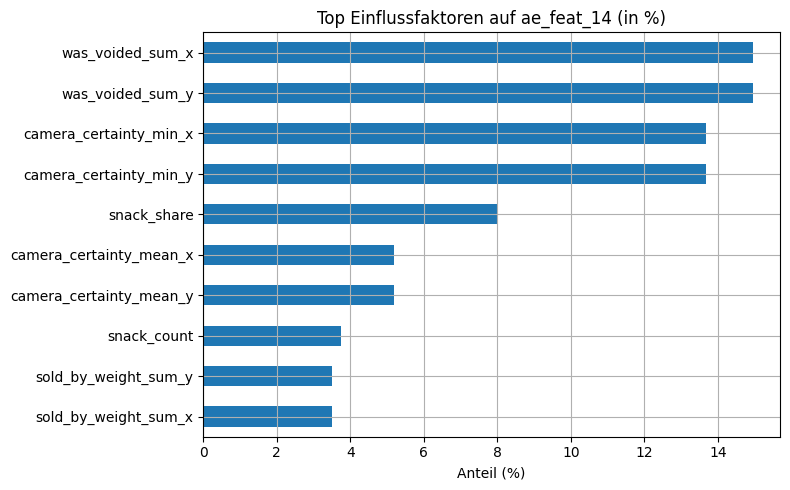


📊 Prozentuale Zusammensetzung von ae_feat_1 (Ridge Regression):
camera_certainty_mean_x    29.800543
camera_certainty_mean_y    29.800543
snack_share                12.060456
camera_certainty_min_x      8.458256
camera_certainty_min_y      8.458256
snack_count                 5.374465
sold_by_weight_sum_x        0.659288
sold_by_weight_sum_y        0.659288
articles_per_minute         0.465796
has_cash_payment            0.442195
dtype: float64


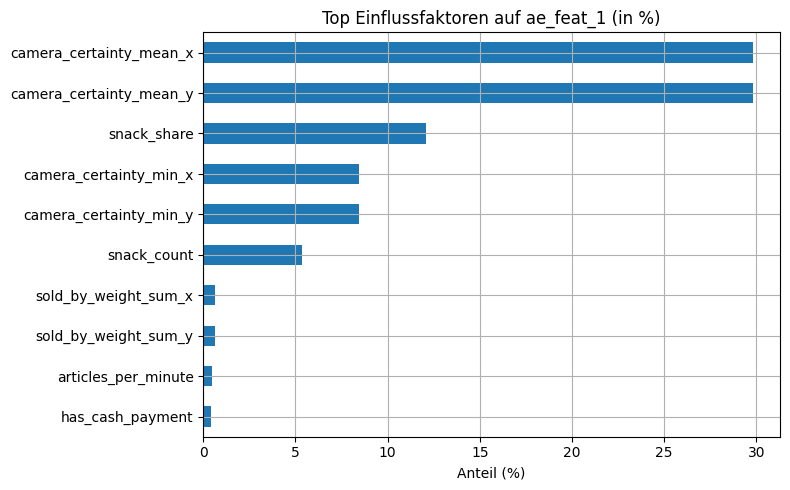


📊 Prozentuale Zusammensetzung von ae_feat_2 (Ridge Regression):
snack_share                45.300995
sold_by_weight_sum_x       11.876889
sold_by_weight_sum_y       11.876889
age_restricted_sum_x        5.531130
age_restricted_sum_y        5.531130
snack_count                 3.300740
camera_certainty_mean_y     3.028887
camera_certainty_mean_x     3.028887
category_nunique_y          1.417851
category_nunique_x          1.417851
dtype: float64


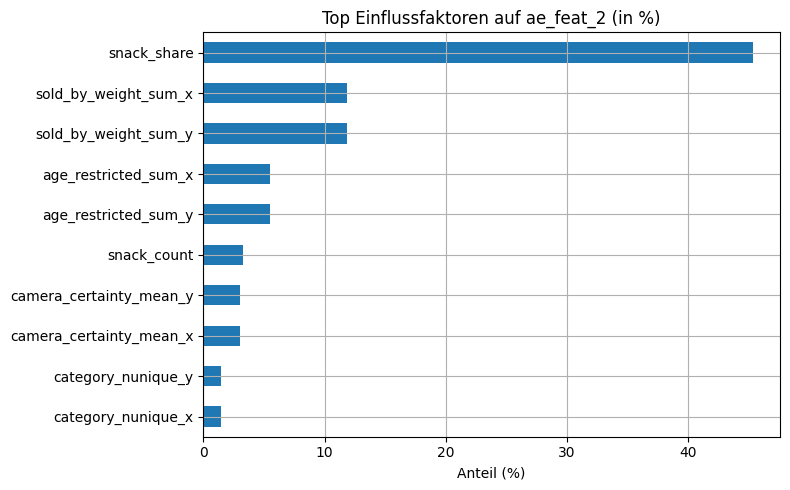


📊 Prozentuale Zusammensetzung von ae_feat_3 (Ridge Regression):
age_restricted_sum_y       19.578444
age_restricted_sum_x       19.578444
snack_share                14.372262
snack_count                12.875067
camera_certainty_min_y      5.713902
camera_certainty_min_x      5.713902
was_voided_sum_x            3.571204
was_voided_sum_y            3.571204
camera_certainty_mean_x     2.391980
camera_certainty_mean_y     2.391980
dtype: float64


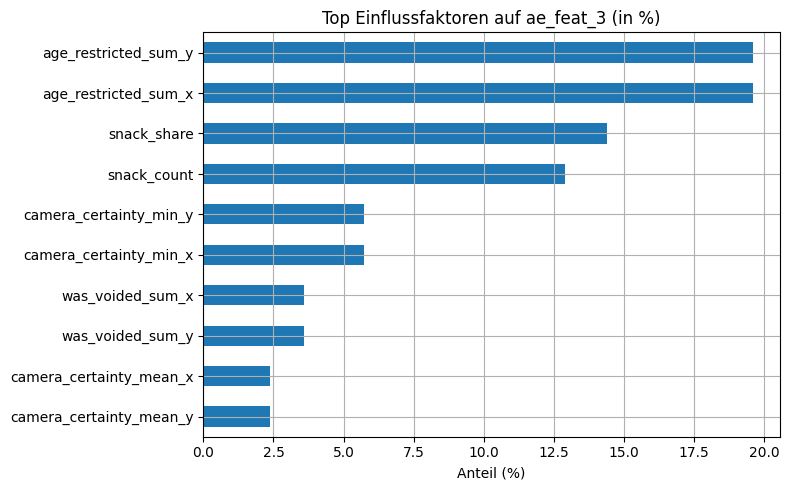


📊 Prozentuale Zusammensetzung von ae_feat_4 (Ridge Regression):
snack_share                40.989587
camera_certainty_mean_x    18.698000
camera_certainty_mean_y    18.698000
sold_by_weight_sum_y        5.374339
sold_by_weight_sum_x        5.374339
snack_count                 2.229443
age_restricted_sum_x        1.452284
age_restricted_sum_y        1.452284
has_cash_payment            1.017030
camera_certainty_min_x      0.758858
dtype: float64


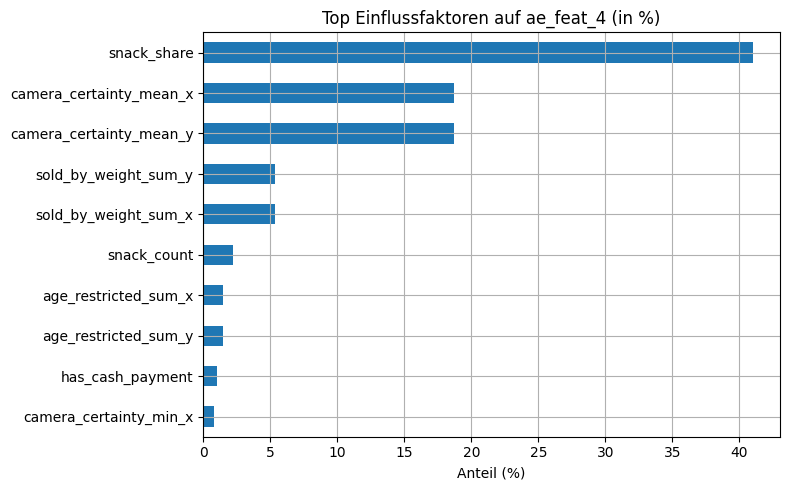


📊 Prozentuale Zusammensetzung von ae_feat_5 (Ridge Regression):
snack_count                14.129587
has_cash_payment           13.876667
snack_share                10.698824
age_restricted_sum_x        8.136533
age_restricted_sum_y        8.136533
camera_certainty_min_x      5.393581
camera_certainty_min_y      5.393581
weekday                     4.446773
camera_certainty_mean_x     4.343366
camera_certainty_mean_y     4.343366
dtype: float64


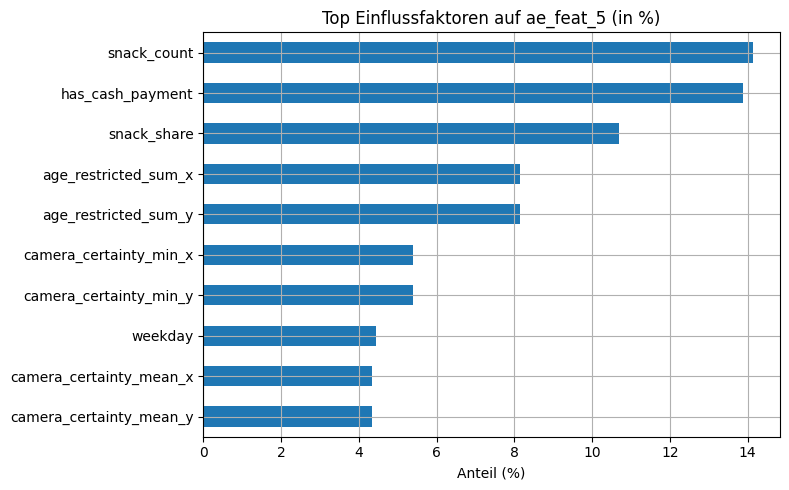


📊 Prozentuale Zusammensetzung von ae_feat_7 (Ridge Regression):
snack_share                14.543097
camera_certainty_mean_y    13.532631
camera_certainty_mean_x    13.532631
sold_by_weight_sum_y       12.702011
sold_by_weight_sum_x       12.702011
snack_count                11.026810
cash_desk                   2.982194
camera_certainty_min_x      2.561848
camera_certainty_min_y      2.561848
age_restricted_sum_x        2.483535
dtype: float64


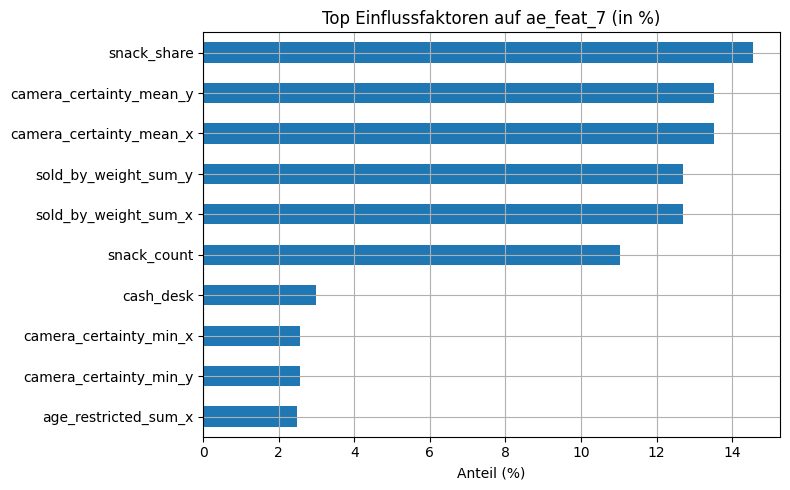


📊 Prozentuale Zusammensetzung von ae_feat_8 (Ridge Regression):
snack_share                  36.704923
age_restricted_sum_x         16.085112
age_restricted_sum_y         16.085112
was_voided_sum_x             13.338678
was_voided_sum_y             13.338678
snack_count                   1.841043
average_price_per_article     1.095510
sales_price_mean_y            0.546481
sales_price_mean_x            0.546481
sold_by_weight_sum_y          0.075666
dtype: float64


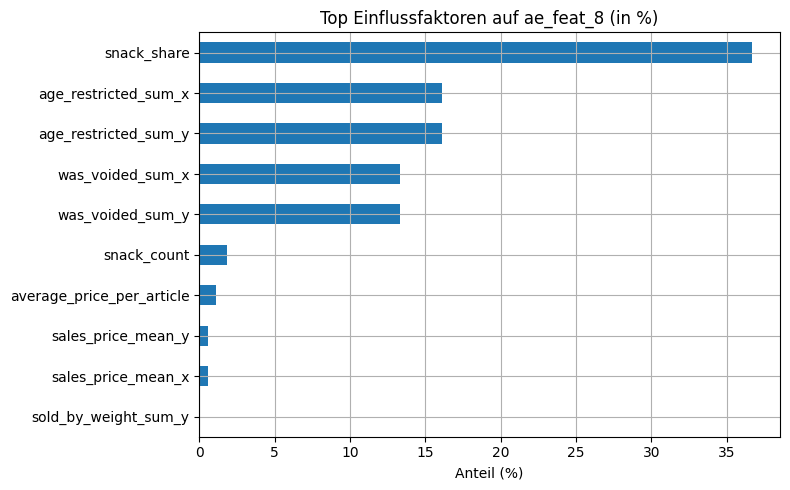


📊 Prozentuale Zusammensetzung von ae_feat_9 (Ridge Regression):
snack_share                34.820777
snack_count                11.467111
camera_certainty_mean_x     9.829492
camera_certainty_mean_y     9.829492
age_restricted_sum_y        5.557443
age_restricted_sum_x        5.557443
cash_desk                   2.934795
camera_certainty_min_y      2.814221
camera_certainty_min_x      2.814221
sold_by_weight_sum_y        2.743546
dtype: float64


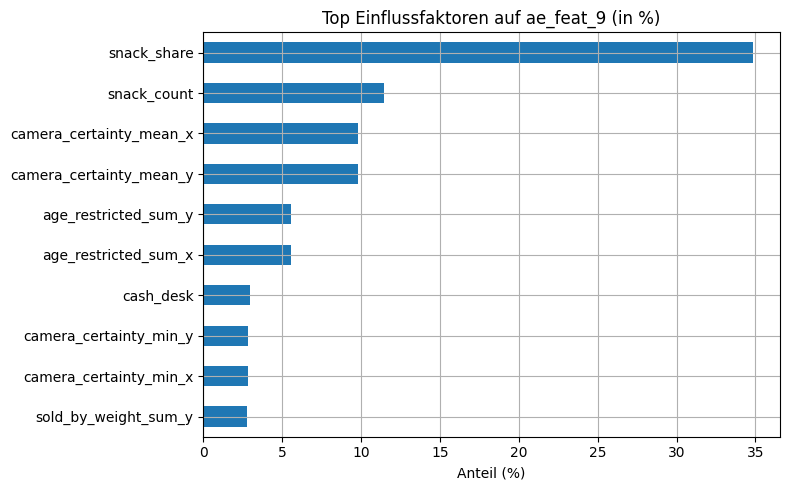


📊 Prozentuale Zusammensetzung von ae_feat_10 (Ridge Regression):
snack_share                47.542035
snack_count                22.503917
sold_by_weight_sum_x        5.053427
sold_by_weight_sum_y        5.053427
camera_certainty_mean_x     3.376222
camera_certainty_mean_y     3.376222
has_cash_payment            2.376868
was_voided_sum_y            1.663693
was_voided_sum_x            1.663693
camera_certainty_min_x      1.595820
dtype: float64


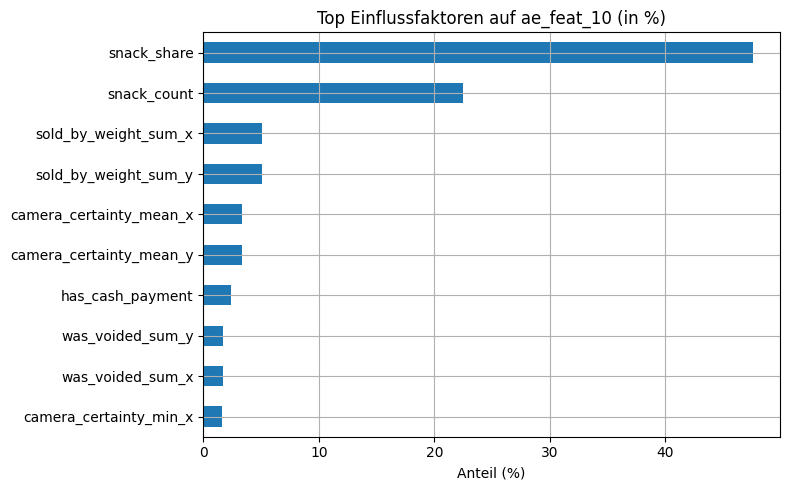


📊 Prozentuale Zusammensetzung von ae_feat_11 (Ridge Regression):
cash_desk                 NaN
total_amount              NaN
n_lines                   NaN
sales_price_sum_x         NaN
sales_price_mean_x        NaN
sales_price_max_x         NaN
camera_certainty_mean_x   NaN
camera_certainty_min_x    NaN
was_voided_sum_x          NaN
category_nunique_x        NaN
dtype: float64


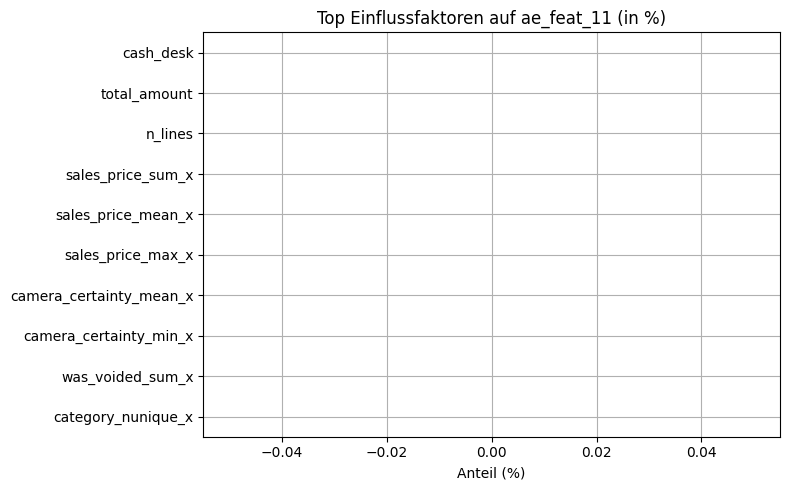


📊 Prozentuale Zusammensetzung von ae_feat_12 (Ridge Regression):
snack_share                40.185087
snack_count                 8.772388
camera_certainty_mean_x     8.684201
camera_certainty_mean_y     8.684201
age_restricted_sum_y        6.673053
age_restricted_sum_x        6.673053
camera_certainty_min_x      4.484110
camera_certainty_min_y      4.484110
was_voided_sum_y            1.798695
was_voided_sum_x            1.798695
dtype: float64


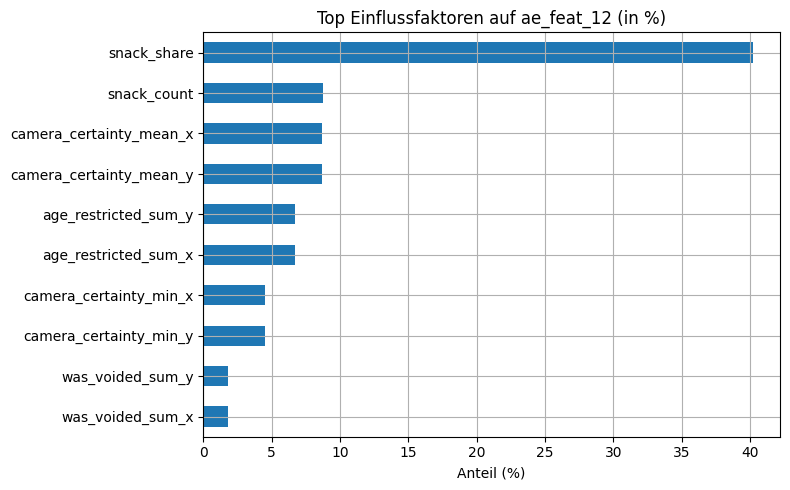


📊 Prozentuale Zusammensetzung von ae_feat_13 (Ridge Regression):
camera_certainty_mean_y    15.544103
camera_certainty_mean_x    15.544103
sold_by_weight_sum_x       11.317618
sold_by_weight_sum_y       11.317618
snack_share                10.089250
camera_certainty_min_y      8.524131
camera_certainty_min_x      8.524131
snack_count                 6.718536
has_cash_payment            3.758629
cash_desk                   2.170012
dtype: float64


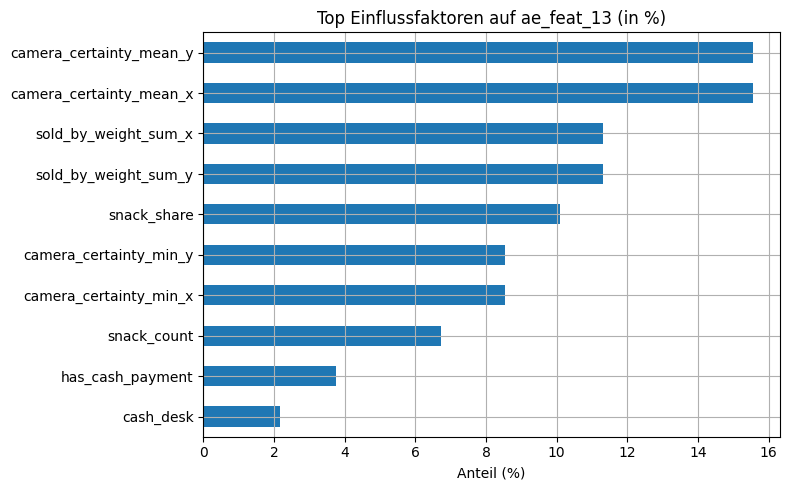


📊 Prozentuale Zusammensetzung von ae_feat_16 (Ridge Regression):
snack_share                57.172913
camera_certainty_min_x      7.470707
camera_certainty_min_y      7.470707
camera_certainty_mean_x     3.827281
camera_certainty_mean_y     3.827281
age_restricted_sum_y        3.029539
age_restricted_sum_x        3.029539
weekday                     2.898569
was_voided_sum_y            2.126157
was_voided_sum_x            2.126157
dtype: float64


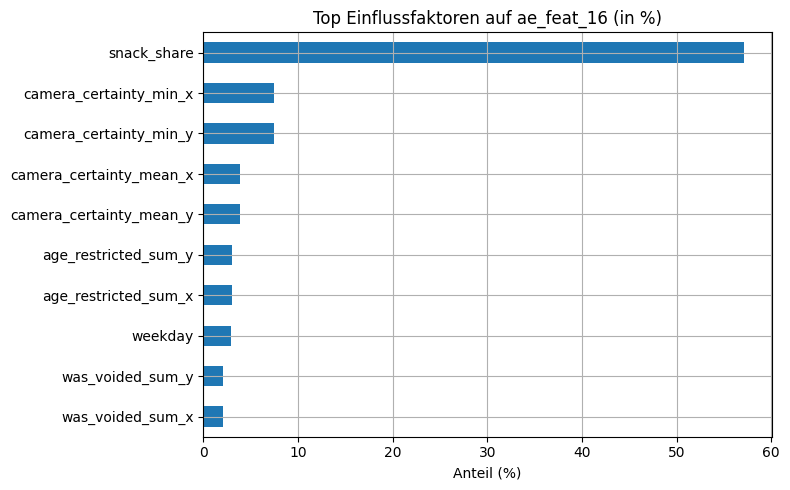


📊 Prozentuale Zusammensetzung von ae_feat_17 (Ridge Regression):
has_cash_payment             98.731405
snack_share                   0.929979
snack_count                   0.074267
average_price_per_article     0.035593
age_restricted_sum_x          0.030724
age_restricted_sum_y          0.030724
sold_by_weight_sum_y          0.030202
sold_by_weight_sum_x          0.030202
sales_price_mean_y            0.017205
sales_price_mean_x            0.017205
dtype: float64


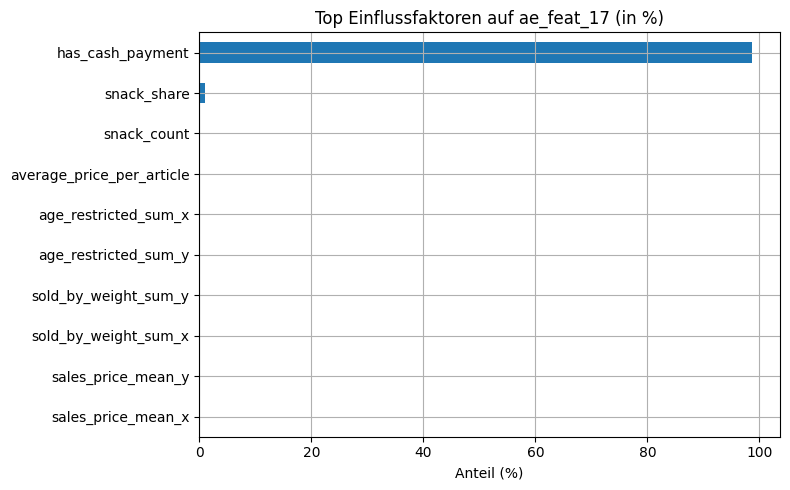


📊 Prozentuale Zusammensetzung von ae_feat_18 (Ridge Regression):
snack_share                41.788274
age_restricted_sum_x        8.820057
age_restricted_sum_y        8.820057
snack_count                 5.976226
camera_certainty_mean_y     5.853983
camera_certainty_mean_x     5.853983
camera_certainty_min_x      3.793558
camera_certainty_min_y      3.793558
sold_by_weight_sum_y        3.186307
sold_by_weight_sum_x        3.186307
dtype: float64


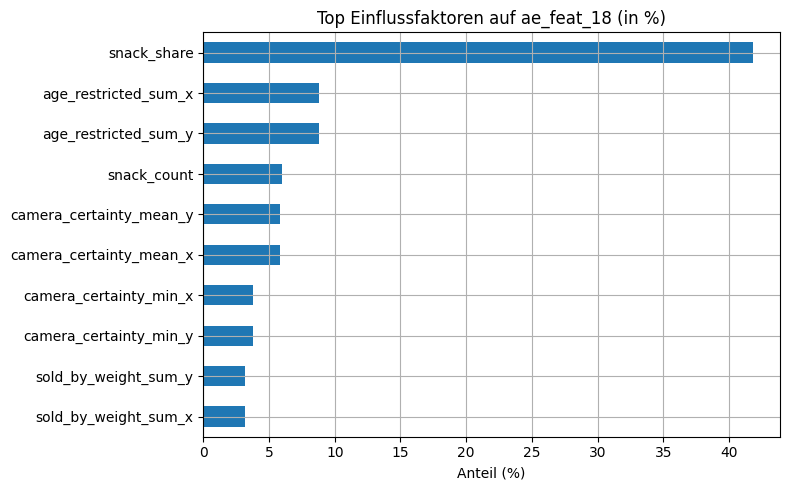


📊 Prozentuale Zusammensetzung von ae_feat_19 (Ridge Regression):
snack_count                31.364493
snack_share                19.739783
age_restricted_sum_x        8.951968
age_restricted_sum_y        8.951968
camera_certainty_mean_x     7.442806
camera_certainty_mean_y     7.442806
camera_certainty_min_y      3.578337
camera_certainty_min_x      3.578337
has_cash_payment            1.863794
cash_desk                   1.217225
dtype: float64


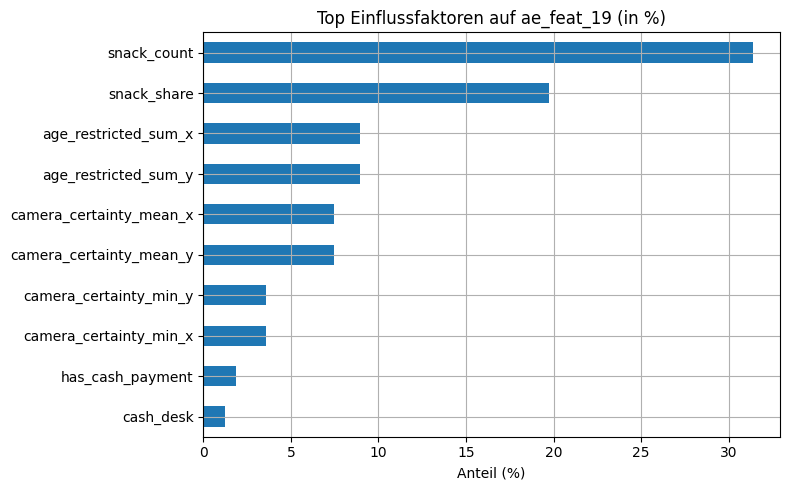


📊 Prozentuale Zusammensetzung von ae_feat_20 (Ridge Regression):
voided_articles_ratio        82.595239
was_voided_sum_x              3.524928
was_voided_sum_y              3.524928
average_price_per_article     2.482922
has_cash_payment              2.117756
sales_price_mean_x            1.244319
sales_price_mean_y            1.244318
camera_certainty_mean_y       0.538929
camera_certainty_mean_x       0.538929
snack_share                   0.314218
dtype: float64


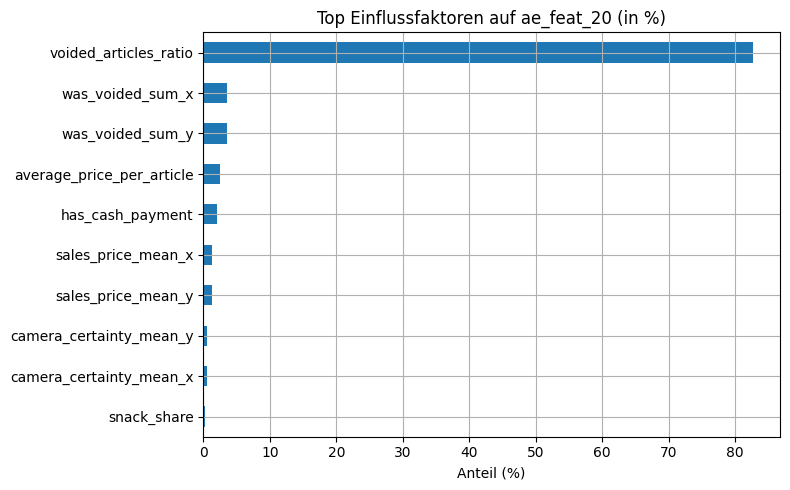


📊 Prozentuale Zusammensetzung von ae_feat_21 (Ridge Regression):
camera_certainty_mean_x    12.839271
camera_certainty_mean_y    12.839271
snack_count                12.472770
age_restricted_sum_x       12.262710
age_restricted_sum_y       12.262710
has_cash_payment            8.321314
snack_share                 5.644629
sold_by_weight_sum_x        5.643156
sold_by_weight_sum_y        5.643156
camera_certainty_min_x      3.296404
dtype: float64


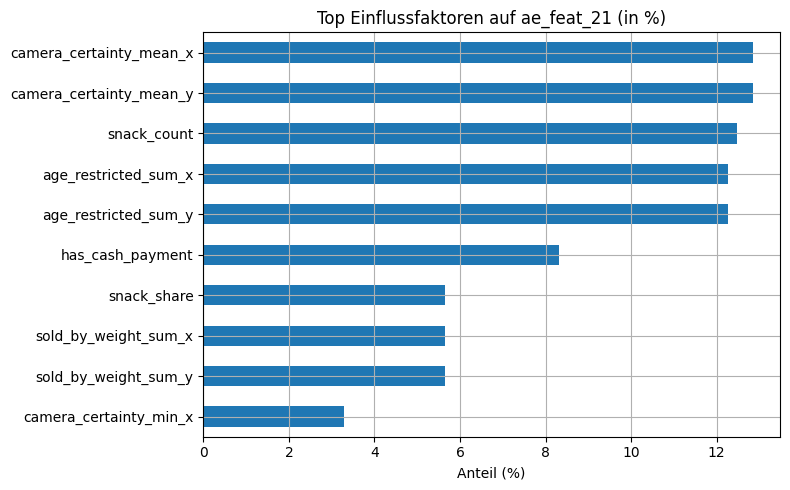


📊 Prozentuale Zusammensetzung von ae_feat_22 (Ridge Regression):
camera_certainty_mean_x    19.858127
camera_certainty_mean_y    19.858127
age_restricted_sum_x       13.752221
age_restricted_sum_y       13.752221
sold_by_weight_sum_y        6.883710
sold_by_weight_sum_x        6.883710
snack_share                 6.003160
was_voided_sum_x            1.993745
was_voided_sum_y            1.993745
articles_per_minute         1.459966
dtype: float64


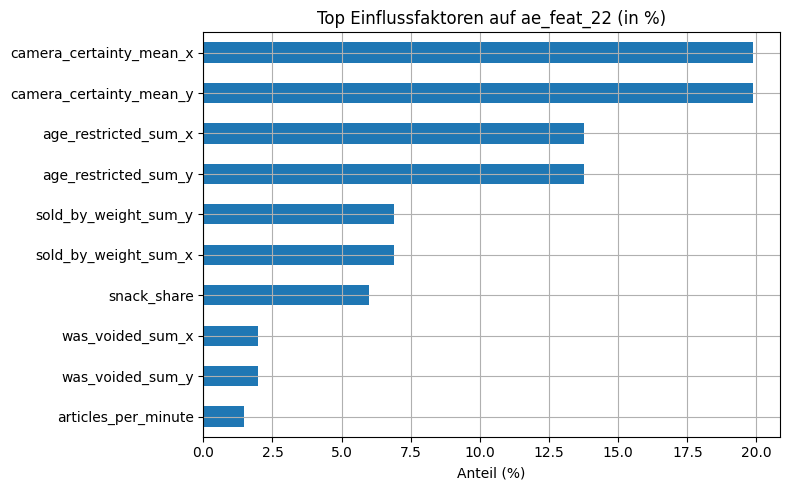


📊 Prozentuale Zusammensetzung von ae_feat_23 (Ridge Regression):
camera_certainty_mean_x    26.200098
camera_certainty_mean_y    26.200098
camera_certainty_min_x      9.651776
camera_certainty_min_y      9.651776
articles_per_minute         3.105170
snack_count                 2.939541
was_voided_sum_y            2.773108
was_voided_sum_x            2.773108
n_lines                     2.191916
snack_share                 1.424611
dtype: float64


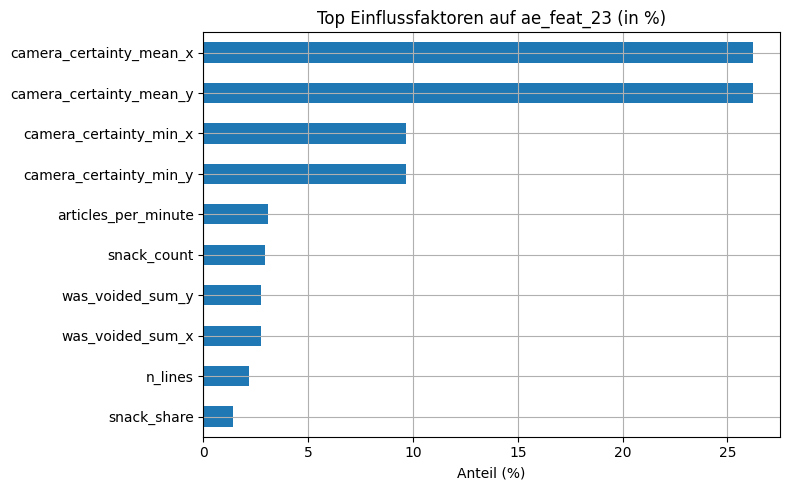


📊 Prozentuale Zusammensetzung von ae_feat_24 (Ridge Regression):
snack_share                32.106827
snack_count                16.732693
age_restricted_sum_y        8.395980
age_restricted_sum_x        8.395980
camera_certainty_min_x      6.471209
camera_certainty_min_y      6.471209
sold_by_weight_sum_y        5.032538
sold_by_weight_sum_x        5.032538
camera_certainty_mean_x     2.206936
camera_certainty_mean_y     2.206936
dtype: float64


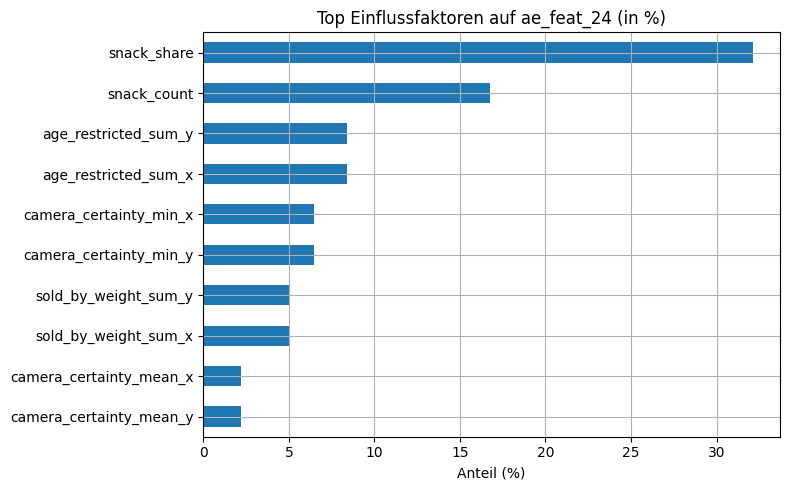


📊 Prozentuale Zusammensetzung von ae_feat_25 (Ridge Regression):
sold_by_weight_sum_y       12.162207
sold_by_weight_sum_x       12.162207
snack_share                11.604549
age_restricted_sum_y       10.731255
age_restricted_sum_x       10.731255
has_cash_payment            7.692365
camera_certainty_mean_x     7.003348
camera_certainty_mean_y     7.003348
camera_certainty_min_y      6.943845
camera_certainty_min_x      6.943845
dtype: float64


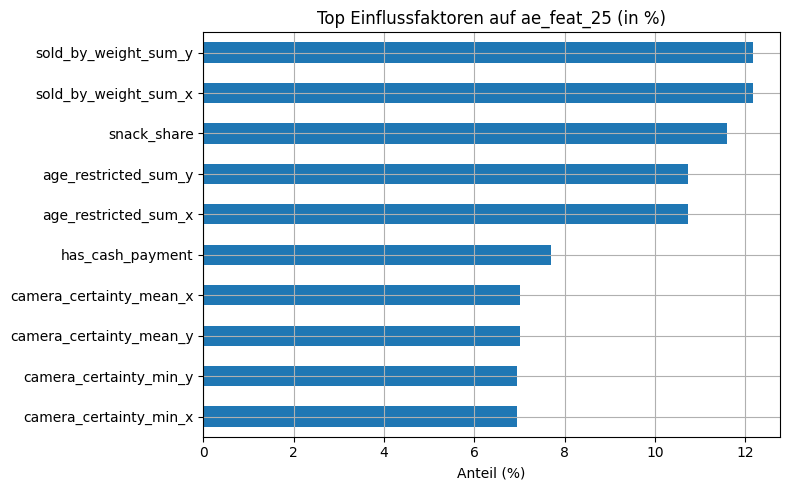


📊 Prozentuale Zusammensetzung von ae_feat_26 (Ridge Regression):
snack_share                66.688605
was_voided_sum_y            5.869186
was_voided_sum_x            5.869186
snack_count                 5.660324
has_cash_payment            5.091198
camera_certainty_min_x      1.713759
camera_certainty_min_y      1.713759
weekday                     1.642847
camera_certainty_mean_x     1.022893
camera_certainty_mean_y     1.022893
dtype: float64


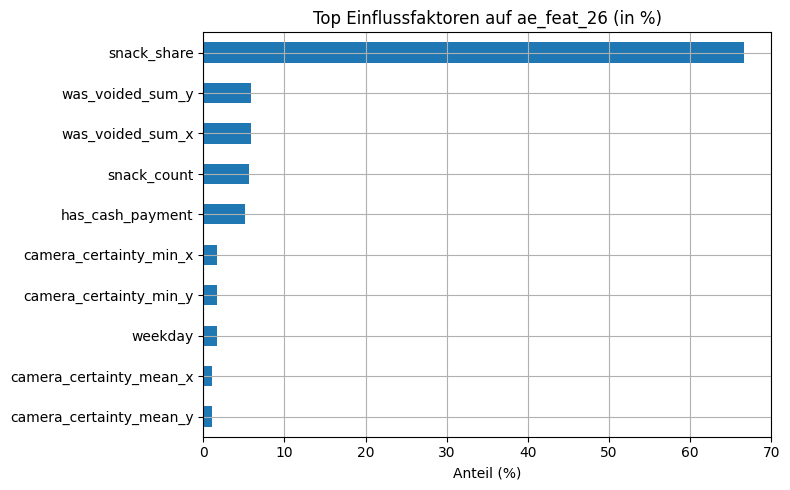


📊 Prozentuale Zusammensetzung von ae_feat_27 (Ridge Regression):
sold_by_weight_sum_x      17.912061
sold_by_weight_sum_y      17.912061
snack_share               11.622590
snack_count               10.925827
age_restricted_sum_y       5.539804
age_restricted_sum_x       5.539804
camera_certainty_min_x     4.655715
camera_certainty_min_y     4.655715
was_voided_sum_y           3.419845
was_voided_sum_x           3.419845
dtype: float64


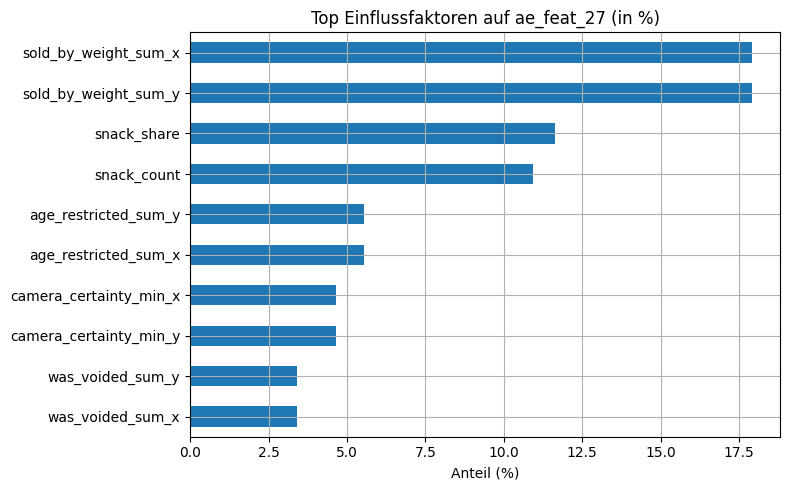


📊 Prozentuale Zusammensetzung von ae_feat_28 (Ridge Regression):
cash_desk                 NaN
total_amount              NaN
n_lines                   NaN
sales_price_sum_x         NaN
sales_price_mean_x        NaN
sales_price_max_x         NaN
camera_certainty_mean_x   NaN
camera_certainty_min_x    NaN
was_voided_sum_x          NaN
category_nunique_x        NaN
dtype: float64


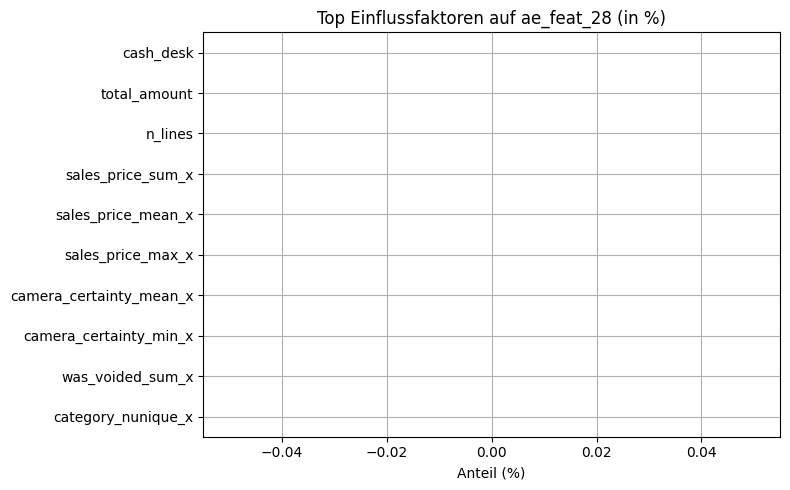


📊 Prozentuale Zusammensetzung von ae_feat_29 (Ridge Regression):
cash_desk                 NaN
total_amount              NaN
n_lines                   NaN
sales_price_sum_x         NaN
sales_price_mean_x        NaN
sales_price_max_x         NaN
camera_certainty_mean_x   NaN
camera_certainty_min_x    NaN
was_voided_sum_x          NaN
category_nunique_x        NaN
dtype: float64


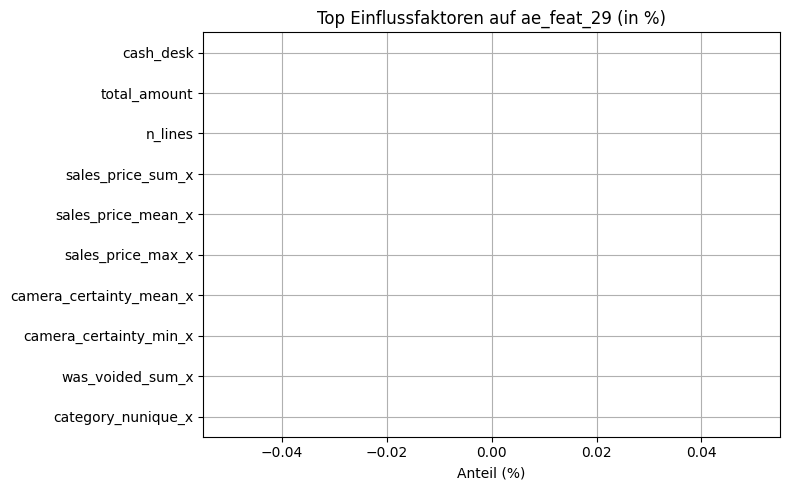


📊 Prozentuale Zusammensetzung von ae_feat_30 (Ridge Regression):
sold_by_weight_sum_y       19.293312
sold_by_weight_sum_x       19.293312
snack_share                10.864386
has_cash_payment            6.693807
camera_certainty_mean_x     6.230696
camera_certainty_mean_y     6.230696
age_restricted_sum_x        6.057884
age_restricted_sum_y        6.057884
camera_certainty_min_x      4.896251
camera_certainty_min_y      4.896251
dtype: float64


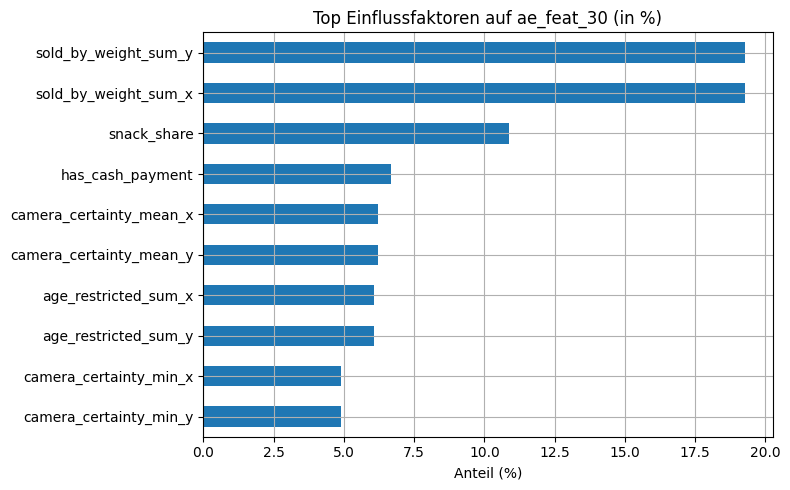


📊 Prozentuale Zusammensetzung von ae_feat_31 (Ridge Regression):
snack_share               47.055361
snack_count                7.830002
was_voided_sum_y           7.214066
was_voided_sum_x           7.214066
camera_certainty_min_x     4.732236
camera_certainty_min_y     4.732236
cash_desk                  3.389989
has_cash_payment           3.198332
sold_by_weight_sum_y       2.788637
sold_by_weight_sum_x       2.788637
dtype: float64


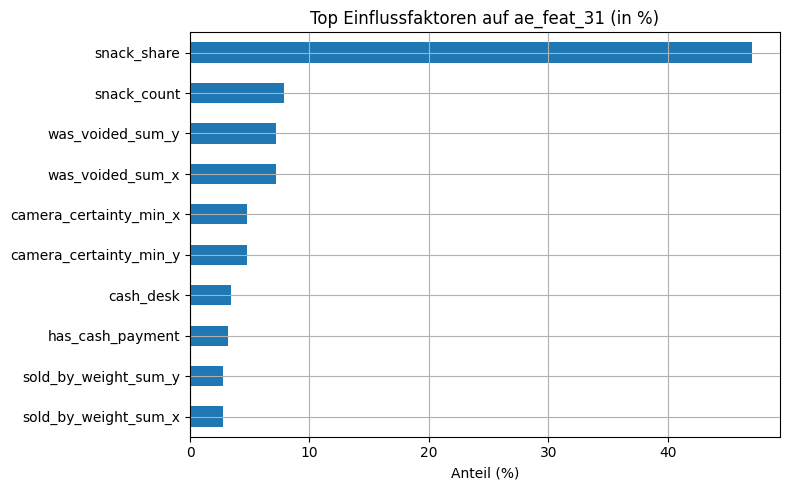

In [68]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

for ae_feat in top_ae_combined:
    print(f"\n📊 Prozentuale Zusammensetzung von {ae_feat} (Ridge Regression):")

    y_target = df[ae_feat]

    # Ridge-Modell trainieren
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_original, y_target)

    # Koeffizienten in Prozent umrechnen
    coefs = pd.Series(ridge.coef_, index=X_original.columns)
    prozent_approx = 100 * coefs.abs() / coefs.abs().sum()
    top_contributors = prozent_approx.sort_values(ascending=False).head(10)

    print(top_contributors)

    # Plot anzeigen
    plt.figure(figsize=(8, 5))
    top_contributors.plot(kind='barh')
    plt.title(f"Top Einflussfaktoren auf {ae_feat} (in %)")
    plt.xlabel("Anteil (%)")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [36]:
# === 4. Feature Importances berechnen ===
importances = model.feature_importances_
features = X.columns

In [37]:
# === 5. Top 20 Features sortieren ===
sorted_idx = importances.argsort()[-30:]  # die 30 wichtigsten

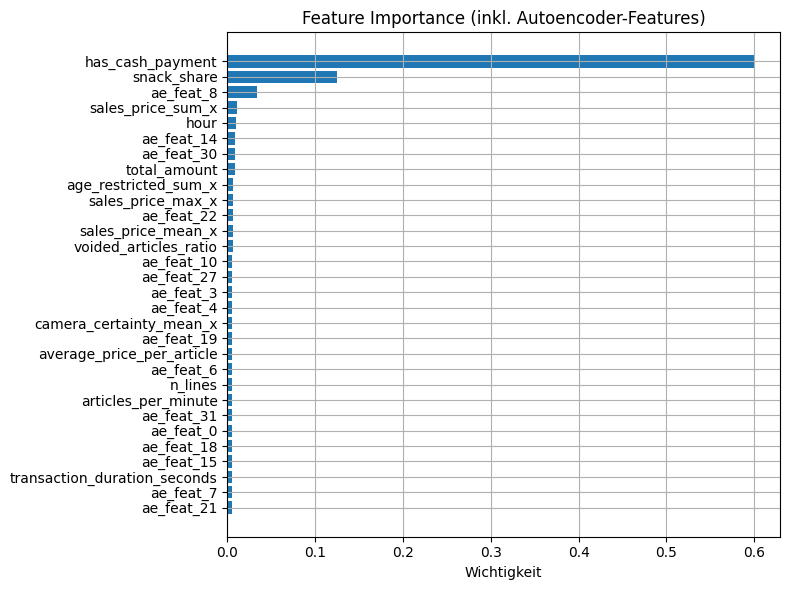

In [38]:
# === 6. Plot ===
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.xlabel("Wichtigkeit")
plt.title("Feature Importance (inkl. Autoencoder-Features)")
plt.tight_layout()
plt.grid(True)
plt.show()

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

In [40]:
# Modellvorhersagen
y_scores = model.predict_proba(X)[:, 1]

In [41]:
# Precision-Recall-Kurve berechnen
precision, recall, thresholds = precision_recall_curve(y, y_scores)
ap = average_precision_score(y, y_scores)

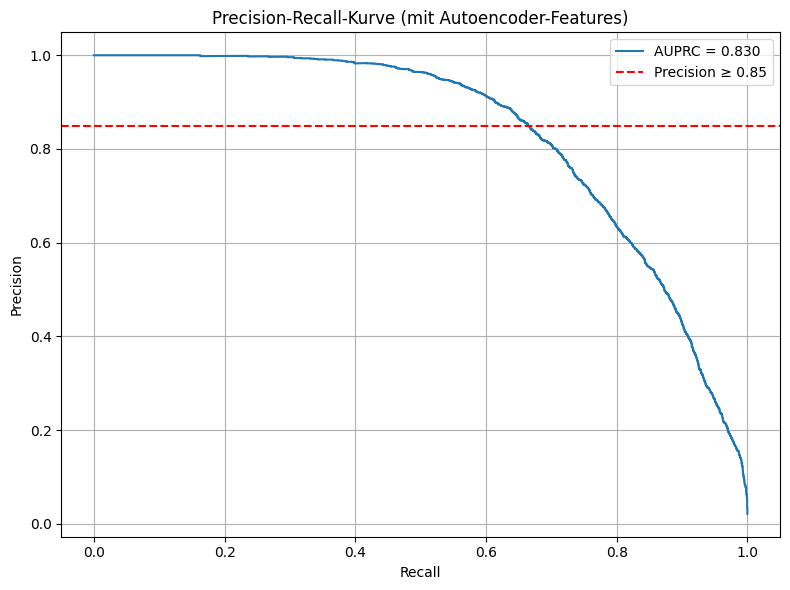

In [42]:
# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUPRC = {ap:.3f}')
plt.axhline(0.85, color='red', linestyle='--', label='Precision ≥ 0.85')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall-Kurve (mit Autoencoder-Features)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


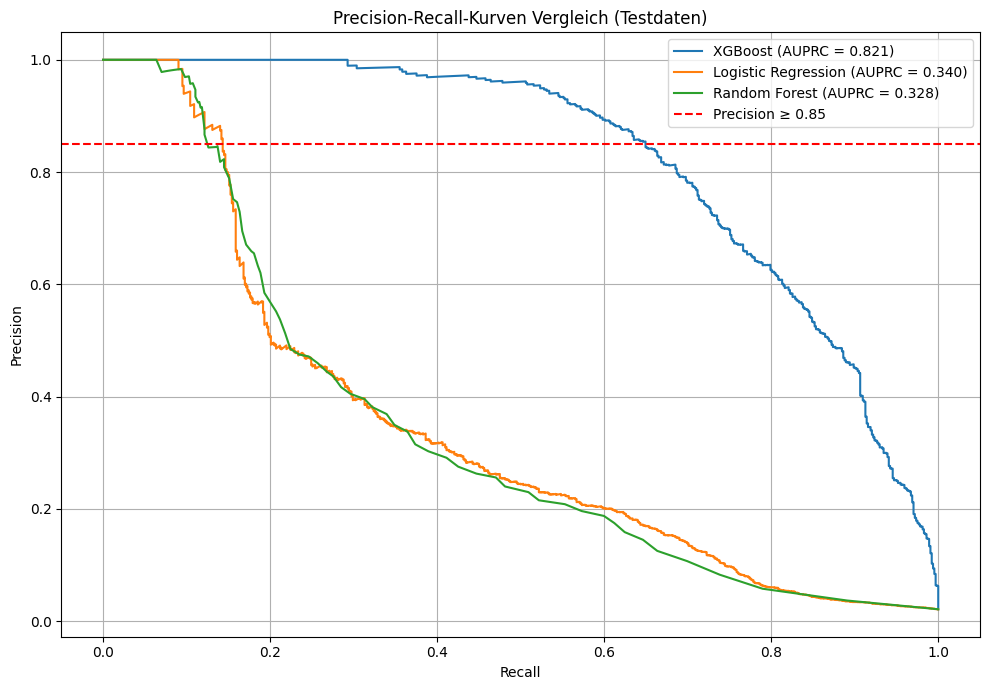


=== Modellmetriken ===
XGBoost              | AUPRC: 0.821 | F1: 0.525 | ROC_AUC: 0.989
Logistic Regression  | AUPRC: 0.340 | F1: 0.235 | ROC_AUC: 0.854
Random Forest        | AUPRC: 0.328 | F1: 0.239 | ROC_AUC: 0.842


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    f1_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# === Sicherstellen, dass X keine NaN-Werte enthält ===
X = X.fillna(X.mean())

# === Train/Test-Split vorbereiten ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelle definieren
models = [
    ("XGBoost", model),  # ← bereits trainiertes Modell!
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42))
]

# === Plot vorbereiten ===
plt.figure(figsize=(10, 7))

# === Metriken speichern ===
metrics_summary = []

for name, clf in models:
    if name != "XGBoost":
        clf.fit(X_train, y_train)

    y_scores = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)  # Standard-Schwelle

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    f1 = f1_score(y_test, y_pred)
    aucroc = roc_auc_score(y_test, y_scores)

    metrics_summary.append({
        "Model": name,
        "AUPRC": ap,
        "F1": f1,
        "ROC_AUC": aucroc
    })

    plt.plot(recall, precision, label=f"{name} (AUPRC = {ap:.3f})")

# === Schwellenwertlinie (Precision) ===
plt.axhline(0.85, color='red', linestyle='--', label='Precision ≥ 0.85')

# === Plot-Einstellungen ===
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall-Kurven Vergleich (Testdaten)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Ausgabe der Metriken ===
print("\n=== Modellmetriken ===")
for m in metrics_summary:
    print(f"{m['Model']:20} | AUPRC: {m['AUPRC']:.3f} | F1: {m['F1']:.3f} | ROC_AUC: {m['ROC_AUC']:.3f}")


In [44]:
# === Testdaten hochladen und vorbereiten ===
from google.colab import files
uploaded_test = files.upload()

# Testdaten laden
df_test = pd.read_csv("df_model_ready_test.csv")  # <–– oder Dateiname aus Upload

Saving df_model_ready_test.csv to df_model_ready_test.csv


In [45]:
# Optional: "damage" entfernen, falls vorhanden
if "damage" in df_test.columns:
    df_test = df_test.drop(columns=["damage"])

# Sicherstellen, dass Target nicht drin ist
if "label_fraud_bin" in df_test.columns:
    df_test = df_test.drop(columns=["label_fraud_bin"])

In [46]:
# Nur numerische Spalten
X_test_raw = df_test.select_dtypes(include=['number'])

# Fehlende Werte auffüllen (wie im Training)
X_test_raw.fillna(X_test_raw.mean(), inplace=True)

In [47]:
# === Achtung: Skalierung muss wie beim Training sein! ===
# → Wenn du `scaler` im Training erstellt hast, verwende ihn wieder
X_test_scaled = scaler.transform(X_test_raw)

# === Autoencoder-Vorhersage (Rekonstruktion) ===
X_test_pred = autoencoder.predict(X_test_scaled)


12815/12815 ━━━━━━━━━━━━━━━━━━━━ 10s 775us/step


In [48]:
# === Rekonstruktionsfehler berechnen ===
reconstruction_error = np.mean((X_test_scaled - X_test_pred) ** 2, axis=1)


# === NEU: Fehler auf Feature-Ebene analysieren ===
import numpy as np
import pandas as pd

# Einzelner Fehler pro Feature
reconstruction_diff = np.abs(X_test_scaled - X_test_pred)

# DataFrame mit Spaltennamen
feature_names = X_test_raw.columns
diff_df = pd.DataFrame(reconstruction_diff, columns=feature_names)

# Top-Fehler pro Zeile
top_feature_per_row = diff_df.idxmax(axis=1)
top_error_value = diff_df.max(axis=1)

# In df_test einfügen
df_test["reconstruction_error"] = reconstruction_error
df_test["most_suspicious_feature"] = top_feature_per_row
df_test["feature_error_value"] = top_error_value

# Flag setzen
threshold = np.percentile(reconstruction_error, 95)
df_test["is_fraud_pred"] = (reconstruction_error > threshold).astype(int)

# Ergebnisse anzeigen
anomalies = df_test[df_test["is_fraud_pred"] == 1]
display(anomalies[["reconstruction_error", "most_suspicious_feature", "feature_error_value"]].head(10))


,reconstruction_error,most_suspicious_feature,feature_error_value
1,0.000703,snack_count,0.114759
29,0.001196,articles_per_minute,0.075441
43,0.000599,snack_count,0.112977
71,0.000975,average_price_per_article,0.087560
72,0.002226,total_amount,0.094949
127,0.064262,average_price_per_article,1.077142
131,0.001308,n_lines,0.099363
137,0.000525,sold_by_weight_sum_x,0.045531
177,0.004778,snack_count,0.281836
202,0.000768,snack_count,0.122278


In [59]:
df_test[df_test['is_fraud_pred'] == 1]

,id,store_id,cash_desk,transaction_start,transaction_end,total_amount,n_lines,payment_medium,sales_price_sum_x,sales_price_mean_x,...,camera_certainty_mean_y,camera_certainty_min_y,was_voided_sum_y,category_nunique_y,sold_by_weight_sum_y,age_restricted_sum_y,reconstruction_error,most_suspicious_feature,feature_error_value,is_fraud_pred
1,5034546a-03c6-441a-9272-ffe7b63c8d7f,75cf982f-abc4-4e88-8d67-70f6767fe5d0,1,2024-01-02 08:10:21.000000,2024-01-02 08:13:24.715841,162.43,23,CREDIT_CARD,162.43,7.062174,...,0.926444,0.318852,0,4,0,0,0.000703,snack_count,0.114759,1
29,53cf3a28-ae5e-48ea-a87e-df563008d723,75cf982f-abc4-4e88-8d67-70f6767fe5d0,1,2024-01-02 12:39:51.000000,2024-01-02 12:41:20.655916,169.72,11,CREDIT_CARD,178.63,14.885833,...,0.823438,0.484251,1,6,0,2,0.001196,articles_per_minute,0.075441,1
43,73a17cac-250c-4bf8-94d8-b93f077e0051,75cf982f-abc4-4e88-8d67-70f6767fe5d0,3,2024-01-02 14:43:03.000000,2024-01-02 14:46:47.455595,215.32,32,CREDIT_CARD,215.32,6.728750,...,0.927401,0.301459,0,6,0,0,0.000599,snack_count,0.112977,1
71,89ab864b-7480-472d-bdb6-e447cacf65aa,75cf982f-abc4-4e88-8d67-70f6767fe5d0,0,2024-01-02 17:32:06.000000,2024-01-02 17:32:59.334716,86.84,6,CREDIT_CARD,87.33,12.475714,...,0.812291,0.267005,1,2,0,0,0.000975,average_price_per_article,0.087560,1
72,85129d2e-8532-4ae8-b64d-8205b5fd0890,75cf982f-abc4-4e88-8d67-70f6767fe5d0,1,2024-01-02 17:41:33.000000,2024-01-02 17:42:51.777525,324.77,14,CREDIT_CARD,324.77,23.197857,...,0.895383,0.754723,0,8,0,2,0.002226,total_amount,0.094949,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409994,f581390b-660b-49c3-877e-e9a628b3e648,f935b53a-3b0a-463c-84f2-ef27a4c16534,1,2024-03-25 11:51:33.000000,2024-03-25 11:54:11.057469,125.38,18,CREDIT_CARD,125.38,6.965556,...,0.932219,0.487032,0,3,0,0,0.000605,snack_count,0.082991,1
409998,42365dfd-df88-4c0d-b5f1-5117ae6b6682,f935b53a-3b0a-463c-84f2-ef27a4c16534,3,2024-03-25 11:57:09.000000,2024-03-25 11:57:32.422030,30.66,1,CASH,30.66,15.330000,...,1.000000,1.000000,1,2,0,0,0.081945,average_price_per_article,1.242329,1
410011,9746a601-43b6-4342-9ce5-34de4484c6fa,f935b53a-3b0a-463c-84f2-ef27a4c16534,3,2024-03-25 12:21:18,2024-03-25 12:24:17.437576,293.01,35,CREDIT_CARD,341.19,9.477500,...,0.950102,0.686747,1,4,0,0,0.001290,total_amount,0.132106,1
410033,971f0e25-b95e-4470-8394-26948a18a9ce,f935b53a-3b0a-463c-84f2-ef27a4c16534,3,2024-03-25 12:53:30,2024-03-25 12:54:11.518974,60.87,5,CREDIT_CARD,60.87,12.174000,...,0.866101,0.549790,0,4,0,1,0.000593,age_restricted_sum_y,0.050470,1


In [61]:
df_test

,id,store_id,cash_desk,transaction_start,transaction_end,total_amount,n_lines,payment_medium,sales_price_sum_x,sales_price_mean_x,...,camera_certainty_mean_y,camera_certainty_min_y,was_voided_sum_y,category_nunique_y,sold_by_weight_sum_y,age_restricted_sum_y,reconstruction_error,most_suspicious_feature,feature_error_value,is_fraud_pred
0,dfd22aae-b87f-4bad-8455-f04885877df1,75cf982f-abc4-4e88-8d67-70f6767fe5d0,0,2024-01-02 08:05:48.000000,2024-01-02 08:07:47.135774,100.32,16,CREDIT_CARD,100.32,6.270000,...,0.917911,0.703022,0,3,0,0,0.000036,sales_price_sum_x,0.011033,0
1,5034546a-03c6-441a-9272-ffe7b63c8d7f,75cf982f-abc4-4e88-8d67-70f6767fe5d0,1,2024-01-02 08:10:21.000000,2024-01-02 08:13:24.715841,162.43,23,CREDIT_CARD,162.43,7.062174,...,0.926444,0.318852,0,4,0,0,0.000703,snack_count,0.114759,1
2,e2900f67-8d3f-4a7e-a745-2bc848b5ba9a,75cf982f-abc4-4e88-8d67-70f6767fe5d0,2,2024-01-02 08:21:12.000000,2024-01-02 08:21:56.652913,32.58,4,CREDIT_CARD,32.58,8.145000,...,0.962318,0.849272,0,2,0,0,0.000030,articles_per_minute,0.011982,0
3,3400ee16-d317-4744-b4a8-049156791104,75cf982f-abc4-4e88-8d67-70f6767fe5d0,3,2024-01-02 08:29:57.000000,2024-01-02 08:30:27.501907,67.50,6,CREDIT_CARD,67.50,11.250000,...,0.916509,0.738017,0,3,0,0,0.000040,camera_certainty_min_y,0.012823,0
4,7e9d4741-2e07-40d5-bcc5-fdfdb65bacb2,75cf982f-abc4-4e88-8d67-70f6767fe5d0,0,2024-01-02 08:31:42.000000,2024-01-02 08:33:09.657265,76.54,10,CREDIT_CARD,85.45,7.768182,...,0.975569,0.863319,1,3,0,0,0.000082,average_price_per_article,0.019107,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410059,7498bb65-527c-418a-93fb-c8b2336fbfa3,f935b53a-3b0a-463c-84f2-ef27a4c16534,1,2024-03-25 13:43:33,2024-03-25 13:43:46.152746,51.07,2,CREDIT_CARD,51.07,25.535000,...,0.907662,0.815323,0,1,0,0,0.000126,hour,0.021110,0
410060,f08483ba-cb20-47cc-accc-988f02a13812,f935b53a-3b0a-463c-84f2-ef27a4c16534,2,2024-03-25 13:45:39,2024-03-25 13:45:57.059191,52.91,3,CREDIT_CARD,52.91,17.636667,...,0.941369,0.824108,0,2,0,0,0.000059,camera_certainty_min_y,0.015907,0
410061,96b142cf-f1ca-4f44-b4de-6277942bfc6b,f935b53a-3b0a-463c-84f2-ef27a4c16534,0,2024-03-25 13:46:00,2024-03-25 13:46:20.813839,32.64,2,CREDIT_CARD,32.64,16.320000,...,0.791881,0.583762,0,2,0,0,0.000061,sales_price_sum_x,0.014563,0
410062,be07c907-01eb-4028-968d-c22a0819289c,f935b53a-3b0a-463c-84f2-ef27a4c16534,3,2024-03-25 13:46:21,2024-03-25 13:46:43.538049,34.16,3,CREDIT_CARD,34.16,11.386667,...,0.930399,0.831097,0,2,0,0,0.000030,camera_certainty_min_y,0.009430,0


In [49]:

# === Ergebnisse speichern ===
#df_test.to_csv("df_test_with_autoencoder_predictions.csv", index=False)
#files.download("df_test_with_autoencoder_predictions.csv")

In [50]:
# === Zeilen anzeigen, die als Anomalien erkannt wurden ===
anomalies = df_test[df_test["is_fraud_pred"] == 1]

# Anzahl und Beispiel
print(f"🔍 Anomalien erkannt: {len(anomalies)} von {len(df_test)} Transaktionen")
print("\n📋 Beispielhafte Anomalien:")

# Erste 10 anzeigen
display(anomalies.head(20))


🔍 Anomalien erkannt: 20504 von 410064 Transaktionen

📋 Beispielhafte Anomalien:


,id,store_id,cash_desk,transaction_start,transaction_end,total_amount,n_lines,payment_medium,sales_price_sum_x,sales_price_mean_x,...,camera_certainty_mean_y,camera_certainty_min_y,was_voided_sum_y,category_nunique_y,sold_by_weight_sum_y,age_restricted_sum_y,reconstruction_error,most_suspicious_feature,feature_error_value,is_fraud_pred
1,5034546a-03c6-441a-9272-ffe7b63c8d7f,75cf982f-abc4-4e88-8d67-70f6767fe5d0,1,2024-01-02 08:10:21.000000,2024-01-02 08:13:24.715841,162.43,23,CREDIT_CARD,162.43,7.062174,...,0.926444,0.318852,0,4,0,0,0.000703,snack_count,0.114759,1
29,53cf3a28-ae5e-48ea-a87e-df563008d723,75cf982f-abc4-4e88-8d67-70f6767fe5d0,1,2024-01-02 12:39:51.000000,2024-01-02 12:41:20.655916,169.72,11,CREDIT_CARD,178.63,14.885833,...,0.823438,0.484251,1,6,0,2,0.001196,articles_per_minute,0.075441,1
43,73a17cac-250c-4bf8-94d8-b93f077e0051,75cf982f-abc4-4e88-8d67-70f6767fe5d0,3,2024-01-02 14:43:03.000000,2024-01-02 14:46:47.455595,215.32,32,CREDIT_CARD,215.32,6.728750,...,0.927401,0.301459,0,6,0,0,0.000599,snack_count,0.112977,1
71,89ab864b-7480-472d-bdb6-e447cacf65aa,75cf982f-abc4-4e88-8d67-70f6767fe5d0,0,2024-01-02 17:32:06.000000,2024-01-02 17:32:59.334716,86.84,6,CREDIT_CARD,87.33,12.475714,...,0.812291,0.267005,1,2,0,0,0.000975,average_price_per_article,0.087560,1
72,85129d2e-8532-4ae8-b64d-8205b5fd0890,75cf982f-abc4-4e88-8d67-70f6767fe5d0,1,2024-01-02 17:41:33.000000,2024-01-02 17:42:51.777525,324.77,14,CREDIT_CARD,324.77,23.197857,...,0.895383,0.754723,0,8,0,2,0.002226,total_amount,0.094949,1
127,1e1b5976-77c4-4980-9b84-5c647489e6a4,75cf982f-abc4-4e88-8d67-70f6767fe5d0,0,2024-01-03 11:51:54.000000,2024-01-03 11:52:15.225702,27.16,1,CASH,27.16,13.580000,...,0.694033,0.418557,1,2,0,0,0.064262,average_price_per_article,1.077142,1
131,be823f6d-f362-4e8b-8144-e84d85ad43c5,75cf982f-abc4-4e88-8d67-70f6767fe5d0,0,2024-01-03 12:20:36.000000,2024-01-03 12:22:10.191732,57.27,5,CREDIT_CARD,57.27,11.454000,...,0.859001,0.471777,0,5,0,1,0.001308,n_lines,0.099363,1
137,5bd493e5-f376-4e93-b71a-922629490d00,75cf982f-abc4-4e88-8d67-70f6767fe5d0,3,2024-01-03 13:55:06.000000,2024-01-03 13:55:36.429536,39.15,4,CREDIT_CARD,39.15,9.787500,...,0.777896,0.653671,0,3,0,1,0.000525,sold_by_weight_sum_x,0.045531,1
177,3b80fa32-792e-482e-9db7-5967bf5005c5,75cf982f-abc4-4e88-8d67-70f6767fe5d0,3,2024-01-03 20:04:00.000000,2024-01-03 20:07:03.428634,180.69,20,CASH,180.69,9.034500,...,0.848510,0.379342,0,7,3,0,0.004778,snack_count,0.281836,1
202,41ac870a-2781-461f-b9b4-b7a8922a2372,75cf982f-abc4-4e88-8d67-70f6767fe5d0,2,2024-01-04 10:04:48.000000,2024-01-04 10:05:18.255183,51.58,4,CREDIT_CARD,51.58,12.895000,...,0.862032,0.521973,0,3,0,0,0.000768,snack_count,0.122278,1


In [51]:
from sklearn.metrics import precision_recall_curve

original_numeric_feature_names = scaler.feature_names_in_


from sklearn.model_selection import train_test_split

X_train_full, X_val_full, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


X_val_for_prediction = X_val_full


y_val_scores = model.predict_proba(X_val_for_prediction)[:, 1]

# Precision, Recall, Thresholds berechnen
precision, recall, thresholds = precision_recall_curve(y_val, y_val_scores) # Use the correct y_val from the re-split

# F1-Werte berechnen
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Index mit bestem F1
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"✅ Best F1-Threshold gefunden: {best_threshold:.4f}")

✅ Best F1-Threshold gefunden: 0.2491


In [52]:
from sklearn.metrics import precision_recall_curve, f1_score

# Wahrscheinlichkeitsscores für Trainingsdaten
y_scores = model.predict_proba(X)[:, 1]

# Precision, Recall und Thresholds berechnen
precision, recall, thresholds = precision_recall_curve(y, y_scores)

# F1-Score zu jedem Threshold berechnen
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Bestes F1-Score finden
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Threshold: {best_threshold:.4f}")
print(f"Precision: {precision[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}, F1: {f1_scores[best_idx]:.4f}")


Threshold: 0.2360
Precision: 0.8120, Recall: 0.6985, F1: 0.7510


In [53]:
import json
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.losses import MeanSquaredError
import shap
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='pandas')


# === Modelle und Scaler laden ===
scaler = joblib.load("scaler.pkl")
autoencoder = load_model("autoencoder_model.h5", custom_objects={'mse': MeanSquaredError()})
model = joblib.load("xgboost_model.pkl")

# Encoder extrahieren
try:
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(name='bottleneck').output)
except ValueError:
    print("Warning: Bottleneck layer not found by name. Using index 3.")
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=3).output)

# === Beispielhafte JSON-Eingabe ===
manual_input = {
    "transaction_header": {
        "store_id": "68474e63266d49ffae282654dfadbe08",
        "cash_desk": 1, #test 1
        "transaction_start": "2023-05-03T18:15:51",
        "transaction_end": "2023-05-03T18:18:39.342449",
        "total_amount": 1042, #1042
        "customer_feedback": 1,
        "payment_medium": "CASH" # Beispiel mit CASH
    },
    "transaction_lines": [
        {
            "id": 1,
            "product_id": "7dce0c72c9a04ea78fc6c8805e06469c",
            "timestamp": "2023-05-03T18:16:13.850824",
            "pieces_or_weight": 1.0,
            "sales_price": 2,
            "was_voided": False,
            "camera_product_similar": True,
            "camera_certainty": 0.9053242508332502
        },
        {
            "id": 2,
            "product_id": "b105997c88974f1ca9aae8012edfa9d9",
            "timestamp": "2023-05-03T18:16:14.571617",
            "pieces_or_weight": 1.0,
            "sales_price": 1.79,
            "was_voided": False,
            "camera_product_similar": True,
            "camera_certainty": 0.98
        },
        {
            "id": 3,
            "product_id": "782c68bfd72f47a1a72337c31bb90c0d",
            "timestamp": "2023-05-03T18:16:17.348562",
            "pieces_or_weight": 1.0,
            "sales_price": 1.19,
            "was_voided": False,
            "camera_product_similar": True,
            "camera_certainty": 0.4
        },
        {
            "id": 4,
            "product_id": "793003e12bae46ff8376ddde17ebef5f",
            "timestamp": "2023-05-03T18:16:23.960201",
            "pieces_or_weight": 1.0,
            "sales_price": 5.00,
            "was_voided": False,
            "camera_product_similar": True,
            "camera_certainty": 0.98
        }
    ]
}

# === Feature-Extraktion ===
def json_to_dataframe(data):
    header = data["transaction_header"]
    lines = data["transaction_lines"]

    df = pd.DataFrame([{
        "cash_desk": header["cash_desk"],
        "total_amount": header["total_amount"],
        "customer_feedback": header["customer_feedback"],
        "num_lines": len(lines),
        "mean_camera_certainty": np.mean([l["camera_certainty"] for l in lines]),
        "voided_count": sum(1 for l in lines if l["was_voided"]),
        "sum_sales_price": sum(l["sales_price"] for l in lines),
        "payment_medium": header["payment_medium"]
    }])

    # Beispielhaft (muss aus deinen Trainingsdaten stammen!):
    all_payment_mediums_from_training = ['CREDIT_CARD', 'CASH']

    # Sicherstellen, dass get_dummies alle trainierten Spalten erzeugt
    payment_dummies = pd.get_dummies(df["payment_medium"], prefix="payment")

    # Füge fehlende Dummys mit 0 hinzu, falls sie nicht in der aktuellen Eingabe sind
    for pm in all_payment_mediums_from_training:
        col_name = f'payment_{pm}'
        if col_name not in payment_dummies.columns:
            payment_dummies[col_name] = 0

    # Entferne Dummys, die nicht in den Trainingsdaten vorkamen (falls durch einen Fehler in all_payment_mediums_from_training)
    payment_dummies = payment_dummies[[f'payment_{pm}' for pm in all_payment_mediums_from_training]]


    df = pd.concat([df.drop(columns=["payment_medium"]), payment_dummies], axis=1)

    return df

# === Vorverarbeitung ===
input_df = json_to_dataframe(manual_input)
original_feature_names = scaler.feature_names_in_

input_df_aligned = pd.DataFrame(0, index=[0], columns=original_feature_names)

for col in input_df.columns:
    if col in input_df_aligned.columns:
        input_df_aligned[col] = input_df[col]
input_df_aligned.fillna(0, inplace=True)


# === Autoencoder-Features ===
X_scaled = scaler.transform(input_df_aligned)
ae_features = encoder.predict(X_scaled)
ae_df = pd.DataFrame(ae_features, columns=[f"ae_feat_{i}" for i in range(ae_features.shape[1])])

# === Kombination aller Features ===
X_processed = pd.concat([input_df_aligned.reset_index(drop=True), ae_df], axis=1)

# === Spalten auswählen ===
try:
    X_final_for_prediction = X_processed[model.feature_names_in_]
except AttributeError:
    print("Warnung: model.feature_names_in_ nicht vorhanden. Versuche, alle Spalten aus X_processed zu verwenden.")
    X_final_for_prediction = X_processed
except KeyError as e:
    print(f"Fehler: Spalte im Input fehlt, die das Modell erwartet: {e}. Überprüfen Sie Feature-Engineering.")
    missing_cols = set(model.feature_names_in_) - set(X_processed.columns)
    for col in missing_cols:
        X_processed[col] = 0 # Füge fehlende Spalten mit 0 hinzu
    X_final_for_prediction = X_processed[model.feature_names_in_]


# === Vorhersage ===
proba = model.predict_proba(X_final_for_prediction)[0][1]
best_threshold = 0.02  # ⬅ aus Validierungsdaten ermittelt und muss klein sein, wegen manuell
is_fraud = proba > best_threshold

# === SHAP (optional) ===
explanation = None
if is_fraud:
    try:
        # Initialisiere Explainer mit dem trainierten Modell und den Daten, die zur Vorhersage verwendet wurden
        explainer = shap.Explainer(model, X_final_for_prediction)
        shap_values = explainer(X_final_for_prediction)

        # Finde den am stärksten beeinflussenden Feature
        top_idx = np.argmax(np.abs(shap_values.values[0]))
        top_feature_name = X_final_for_prediction.columns[top_idx]
        top_feature_value = float(X_final_for_prediction.iloc[0, top_idx])
        top_shap_value = float(shap_values.values[0][top_idx])

        explanation = {
            "most_influential_feature": top_feature_name,
            "reason": f"'{top_feature_name}' beeinflusste die Fraud-Wahrscheinlichkeit am staerksten mit einem Wert von {top_feature_value}."
        }
    except Exception as e:
        explanation = {"reason": f"SHAP-Fehler: {str(e)}"}

# === Ausgabe ===
output = {
    "version": "0.4",
    "is_fraud": bool(is_fraud),
    "fraud_proba": float(proba),
    "estimated_damage": manual_input["transaction_header"]["total_amount"] * 0.2229 if is_fraud else None,
    "explanation": explanation
}

print(json.dumps(output, indent=2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
{
  "version": "0.4",
  "is_fraud": false,
  "fraud_proba": 0.005366550758481026,
  "estimated_damage": null,
  "explanation": null
}


In [54]:
# === FRAUD-Vorhersagen auf dem Trainingsset (X) berechnen ===
train_pred_proba = model.predict_proba(X)[:, 1]
train_pred_label = (train_pred_proba > 0.2).astype(int) # 0.2 ist sweetspot

# === Zusammenfassen ===
fraud_pred_count = (train_pred_label == 1).sum()
nonfraud_pred_count = (train_pred_label == 0).sum()

print("\n=== 📊 Modell-Vorhersage auf Trainingsdaten ===")
print(f"🚨 Als Fraud erkannt:       {fraud_pred_count}")
print(f"✅ Als Nicht-Fraud erkannt: {nonfraud_pred_count}")
print(f"📦 Gesamt:                  {len(train_pred_label)}")



=== 📊 Modell-Vorhersage auf Trainingsdaten ===
🚨 Als Fraud erkannt:       3281
✅ Als Nicht-Fraud erkannt: 148284
📦 Gesamt:                  151565


In [55]:
# Zeilen mit als Fraud erkannten Fällen anzeigen
fraud_predicted_rows = X[train_pred_label == 1]
print("\n🧾 Zeilen mit als Fraud erkannten Fällen:")
print(fraud_predicted_rows)



🧾 Zeilen mit als Fraud erkannten Fällen:
        cash_desk  total_amount  n_lines  sales_price_sum_x  \
146             3         79.07        8              79.07   
315             3          1.39        1               1.39   
352             3         66.86       10              66.86   
384             3          3.77        2               3.77   
424             2        114.06       10             114.06   
...           ...           ...      ...                ...   
151394          2          1.96        1               1.96   
151398          0          7.84        1               7.84   
151503          2         57.18       12              57.18   
151521          0        117.67       20             117.67   
151540          1         57.01        6              57.01   

        sales_price_mean_x  sales_price_max_x  camera_certainty_mean_x  \
146               9.883750              35.26                 0.336263   
315               1.390000               1.39        

In [56]:
from google.colab import files

# Download der Modell-Datei
files.download("xgboost_model.pkl")

# Optional: auch die Feature-Namen, falls du sie später brauchst
files.download("feature_names.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
import joblib

model_features = joblib.load("feature_names.pkl")
print(model_features)


['cash_desk' 'total_amount' 'n_lines' 'sales_price_sum_x'
 'sales_price_mean_x' 'sales_price_max_x' 'camera_certainty_mean_x'
 'camera_certainty_min_x' 'was_voided_sum_x' 'category_nunique_x'
 'sold_by_weight_sum_x' 'age_restricted_sum_x' 'has_cash_payment'
 'average_price_per_article' 'transaction_duration_seconds'
 'articles_per_minute' 'voided_articles_ratio' 'hour' 'weekday'
 'snack_count' 'snack_share' 'sales_price_sum_y' 'sales_price_mean_y'
 'sales_price_max_y' 'camera_certainty_mean_y' 'camera_certainty_min_y'
 'was_voided_sum_y' 'category_nunique_y' 'sold_by_weight_sum_y'
 'age_restricted_sum_y' 'ae_feat_0' 'ae_feat_1' 'ae_feat_2' 'ae_feat_3'
 'ae_feat_4' 'ae_feat_5' 'ae_feat_6' 'ae_feat_7' 'ae_feat_8' 'ae_feat_9'
 'ae_feat_10' 'ae_feat_11' 'ae_feat_12' 'ae_feat_13' 'ae_feat_14'
 'ae_feat_15' 'ae_feat_16' 'ae_feat_17' 'ae_feat_18' 'ae_feat_19'
 'ae_feat_20' 'ae_feat_21' 'ae_feat_22' 'ae_feat_23' 'ae_feat_24'
 'ae_feat_25' 'ae_feat_26' 'ae_feat_27' 'ae_feat_28' 'ae_feat_29'
 'a

📊 Rückgerechnete Modellanalyse
✅ Vom Modell erkannte Fraud-Fälle (TP): 32486
🚫 False Positives (FP): 7522
🧮 Geschätzte Gesamtzahl echter Fraud-Fälle: 46509
💰 Verhinderter Schaden: 259891.97 €
💸 FP-Kosten: 79953.59 €
📈 Netto-Nutzen: 179938.38 €


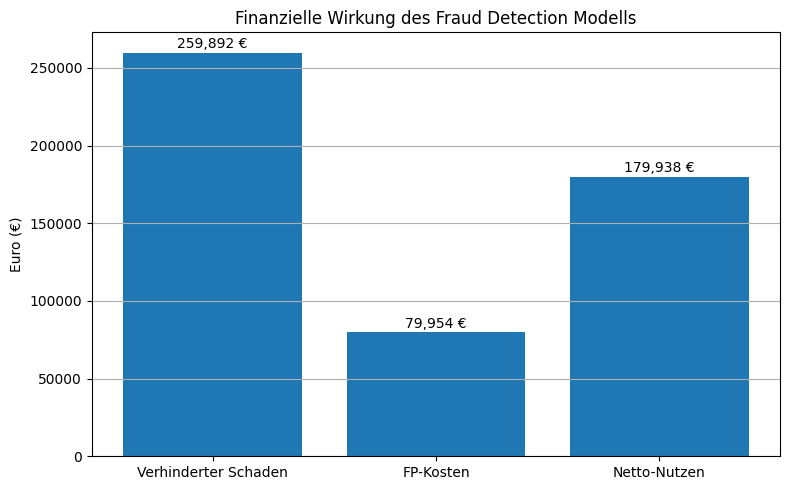

In [73]:
import matplotlib.pyplot as plt

# Gegebene Werte
positive_predictions = 40008       # Vom Modell als Fraud markiert
precision = 0.8120
recall = 0.6985
schaden_pro_fraud = 8              # € -> sozusagen der gewinn weil man den schaden verhindert hat
kosten_pro_fp = 10.63                 # 10€Fix+Kosten für aufwand der Arbeitskraft (0.63) standartgehalt 15€die stunde 2,5 minuten aufwand. Warenwertanteil nicht dazugerechnet, da der einkauf trotzdem vollzogen wurde

# Berechnungen
tp = precision * positive_predictions
fp = positive_predictions - tp
total_fraud_fälle = tp / recall
verhinderter_schaden = tp * schaden_pro_fraud
fp_kosten = fp * kosten_pro_fp
netto_nutzen = verhinderter_schaden - fp_kosten

# Ausgabe
print("📊 Rückgerechnete Modellanalyse")
print(f"✅ Vom Modell erkannte Fraud-Fälle (TP): {tp:.0f}")
print(f"🚫 False Positives (FP): {fp:.0f}")
print(f"🧮 Geschätzte Gesamtzahl echter Fraud-Fälle: {total_fraud_fälle:.0f}")
print(f"💰 Verhinderter Schaden: {verhinderter_schaden:.2f} €")
print(f"💸 FP-Kosten: {fp_kosten:.2f} €")
print(f"📈 Netto-Nutzen: {netto_nutzen:.2f} €")

# Plot
labels = ['Verhinderter Schaden', 'FP-Kosten', 'Netto-Nutzen']
values = [verhinderter_schaden, fp_kosten, netto_nutzen]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values)
plt.title("Finanzielle Wirkung des Fraud Detection Modells")
plt.ylabel("Euro (€)")
plt.grid(axis='y')

# Werte auf die Balken schreiben
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1000, f"{yval:,.0f} €", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [74]:
# Vorher berechnete Werte:
netto_nutzen = 179938  # Beispiel aus vorherigem Code
anzahl_Kunden = 410064 * 2  # = 820128
anzahl_kunden_fraud = 40008  # Beispiel: Anzahl einzigartiger Kunden (anpassbar)

# Berechnungen
nutzen_pro_fall = netto_nutzen / anzahl_Kunden
nutzen_pro_kunde = netto_nutzen / anzahl_kunden_fraud

# Ausgabe
print("💶 Durchschnittlicher wirtschaftlicher Nutzen:")
print(f"➡️  Pro Kunden: {nutzen_pro_fall:.4f} €")
print(f"➡️  Pro kunden_fraud:       {nutzen_pro_kunde:.4f} €")


💶 Durchschnittlicher wirtschaftlicher Nutzen:
➡️  Pro Kunden: 0.2194 €
➡️  Pro kunden_fraud:       4.4976 €
